# Developmental EEG Data 

This notebook analyzes a large dataset of EEG, collected from a developmental sample.

## Dataset Details

This analysis uses the 
[MIPDB dataset](http://fcon_1000.projects.nitrc.org/indi/cmi_eeg/) from the 
[ChildMind Institute](https://childmind.org/).

Note that the pre-processing of the data as available in the dataset, doing data cleaning and calculating power spectra, is done external to this project.

In [1]:
import csv
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import mne
from mne.viz import plot_topomap

from fooof import FOOOF
from fooof.utils import trim_spectrum

from neurodsp.utils import create_times
from neurodsp.spectral import compute_spectrum
from neurodsp.plts import plot_time_series, plot_power_spectra

/var/folders/59/8y2d5r257c77vzymnqs47x080000gn/T/ipykernel_75733/3859869960.py:11: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOF


In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.io import APMDB
from apm.run import run_measures, run_group_measures
from apm.analysis import (compute_avgs, compute_all_corrs, compute_corrs_to_feature,
                          compute_diffs_to_feature, unpack_corrs)
from apm.plts import plot_dots, plot_corr_matrix
from apm.plts.multi import plot_results_all
from apm.plts.utils import make_axes
from apm.plts.settings import EXT
from apm.methods import (autocorr_decay_time, hurst, dfa, higuchi_fd, hjorth_complexity,
                         lempelziv, app_entropy, perm_entropy, specparam, irasa)
from apm.methods.settings import (AC_DECAY_PARAMS, HURST_PARAMS, DFA_PARAMS, HFD_PARAMS,
                                  HJC_PARAMS, LZ_PARAMS, AP_ENT_PARAMS, PE_ENT_PARAMS)
from apm.methods.periodic import alpha_power
from apm.utils import format_corr

In [3]:
import seaborn as sns
sns.set_context('talk')

## Settings

In [4]:
# Data path
data_path = Path('/Users/tom/Data/VoytekLab/ExtractedSubsets/childmind/')

In [5]:
# Define data information
fs = 500
n_seconds = 30

In [6]:
# Define times vector for data
times = create_times(n_seconds + 1/fs, fs)

In [7]:
# Add plot kwargs
dot_kwargs = {
    's' : 24,
    'alpha' : 0.7,
}

In [8]:
# Settings for saving figures
SAVE_FIG = True
FIGPATH = APMDB().figs_path / '52_dev_data'

## Load Data

In [9]:
# Load data files
ages = np.load(data_path / 'ages.npy')
data = np.load(data_path / 'data.npy')

In [10]:
# Check the number of subjects
n_subjs = data.shape[0]
assert n_subjs == len(ages)
print('Number of subjects: {}'.format(n_subjs))

Number of subjects: 111


## Data Checks

In [11]:
ind = 0

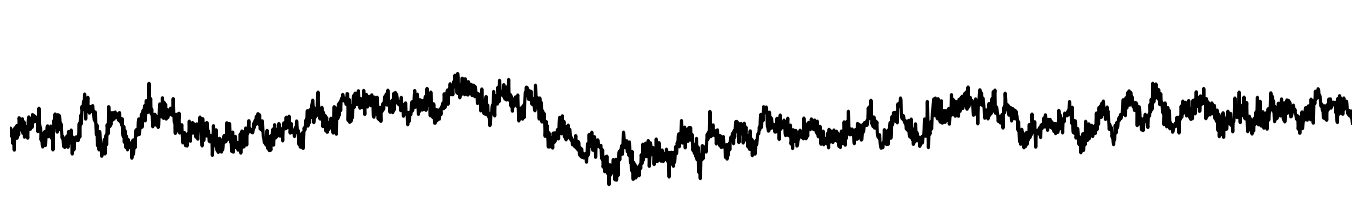

In [12]:
# Plot a segment of time series data
plot_time_series(times, data[ind, :], xlim=[5, 10])
plt.gca().axis('off');
if SAVE_FIG: plt.savefig(FIGPATH / ('eeg_timeseries' + EXT))

In [13]:
# Compute a power spectrum of an example
freqs, powers = compute_spectrum(data[ind, :], fs, nperseg=2*fs, noverlap=fs)

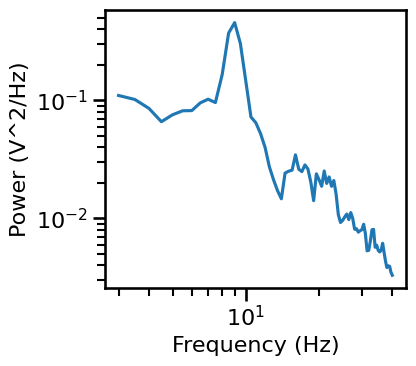

In [14]:
plot_power_spectra(*trim_spectrum(freqs, powers, [3, 40]), figsize=(4.5, 4), 
                   save_fig=SAVE_FIG, file_name='rest_eeg_psd' + EXT, file_path=FIGPATH)

## Compute Measures Methods

This is a replication of the analysis in the initial EEG dataset. 

### Aperiodic Methods

In [15]:
# Initialize specparam model
fm = FOOOF(verbose=False)

In [16]:
# General method settings
f_range = [3, 40]
specparam_kwargs = {'min_peak_height' : 0.05, 'fs' : fs, 'f_range' : f_range}
irasa_kwargs = {'fs' : fs, 'f_range' : f_range}

In [17]:
# Define measures to apply
measures = {
    autocorr_decay_time : AC_DECAY_PARAMS,
    hurst : HURST_PARAMS,
    dfa : DFA_PARAMS,
    higuchi_fd : HFD_PARAMS,
    hjorth_complexity : HJC_PARAMS,
    lempelziv : LZ_PARAMS,
    app_entropy : AP_ENT_PARAMS,
    perm_entropy : PE_ENT_PARAMS,
    specparam : specparam_kwargs,
    irasa : irasa_kwargs,
}

In [18]:
# Compute measures of interest on the data
results = run_measures(data, measures)

In [19]:
# Compute correlations across all pairs of methods
all_corrs = compute_all_corrs(results)

In [20]:
# Collect list of exponent & timeseries measure labels
exp_measures = ['specparam', 'irasa']
ts_measures = list(results.keys())
[ts_measures.remove(meas) for meas in exp_measures];

## Peak Measures

In [21]:
# Define periodic measures to compute
peak_measures = {alpha_power : measures[specparam]}

In [22]:
# Compute periodic measures
peak_results = run_measures(data, peak_measures)

## Compare Measures

#### Compare Exponent Measures

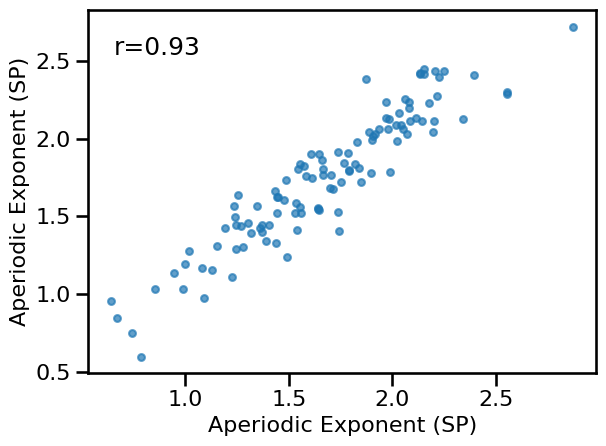

In [23]:
# Plot the comparison of specparam and IRASA exponent estimations
plot_dots(results['specparam'], results['irasa'], **dot_kwargs, tposition='tl',
          xlabel='Aperiodic Exponent (SP)', ylabel='Aperiodic Exponent (SP)',
          save_fig=SAVE_FIG, file_name='mipdb_exp_exp_comp' + EXT, file_path=FIGPATH)

In [24]:
# Check correlation between specparam and irasa exponent estimates
print('  SP-EXP & IR-EXP:  ', format_corr(*all_corrs['specparam']['irasa']))

  SP-EXP & IR-EXP:   r=+0.932  CI[+0.895, +0.954],  p=0.000


### Compare Exponent to Time Series Measures

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


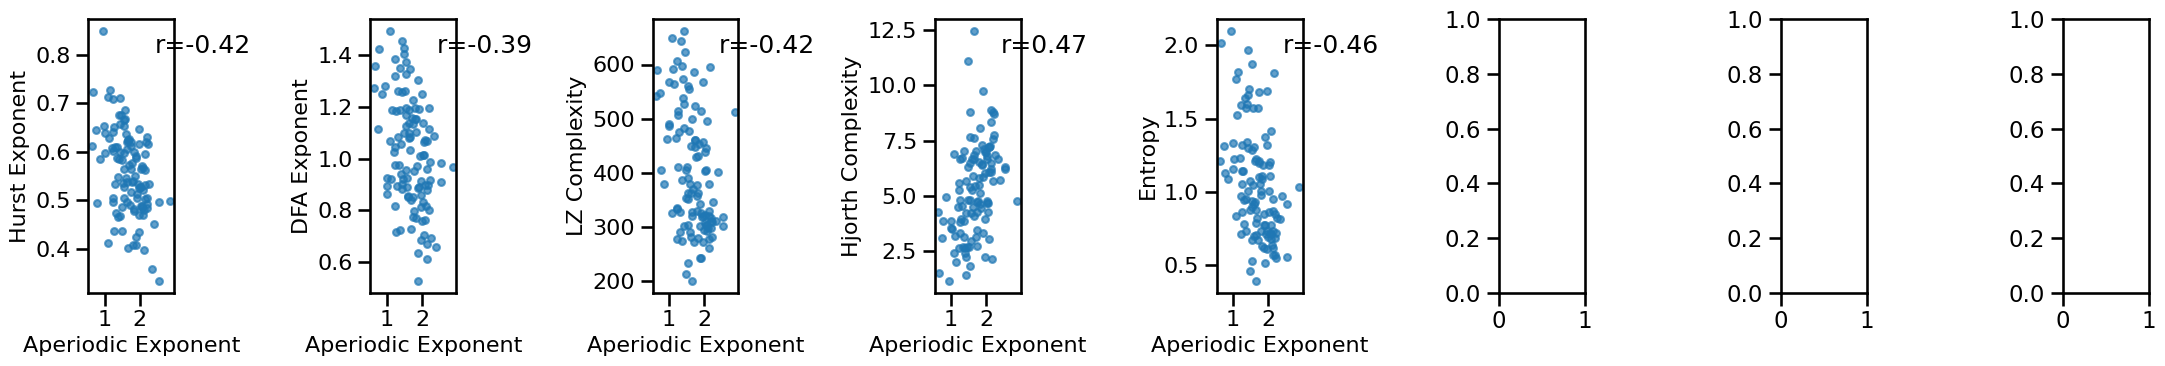

In [25]:
axes = make_axes(1, len(ts_measures), figsize=(22, 4), wspace=0.1)
plot_dots(results['specparam'], results['hurst'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hurst Exponent', ax=axes[0])
plot_dots(results['specparam'], results['dfa'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='DFA Exponent', ax=axes[1])
plot_dots(results['specparam'], results['lempelziv'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='LZ Complexity', ax=axes[2])
plot_dots(results['specparam'], results['hjorth_complexity'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Hjorth Complexity', ax=axes[3])
plot_dots(results['specparam'], results['app_entropy'], **dot_kwargs,
          xlabel='Aperiodic Exponent', ylabel='Entropy', ax=axes[4])
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_ts_scatters' + EXT))

In [26]:
# Check the correlations between time series and exponent measures
print('  SP-EXP & Hurst:  ', format_corr(*all_corrs['specparam']['hurst']))
print('  IR-EXP & Hurst:  ', format_corr(*all_corrs['irasa']['hurst']))
print('  SP-EXP & DFA:    ', format_corr(*all_corrs['specparam']['dfa']))
print('  IR-EXP & DFA:    ', format_corr(*all_corrs['irasa']['dfa']))
print('  SP-EXP & LZC:    ', format_corr(*all_corrs['specparam']['lempelziv']))
print('  IR-EXP & LZC:    ', format_corr(*all_corrs['irasa']['lempelziv']))
print('  SP-EXP & HJC:    ', format_corr(*all_corrs['specparam']['hjorth_complexity']))
print('  IR-EXP & HJC:    ', format_corr(*all_corrs['irasa']['hjorth_complexity']))
print('  SP-EXP & ENT:    ', format_corr(*all_corrs['specparam']['app_entropy']))
print('  IR-EXP & ENT:    ', format_corr(*all_corrs['irasa']['app_entropy']))

  SP-EXP & Hurst:   r=-0.425  CI[-0.579, -0.245],  p=0.000
  IR-EXP & Hurst:   r=-0.317  CI[-0.483, -0.137],  p=0.001
  SP-EXP & DFA:     r=-0.391  CI[-0.531, -0.228],  p=0.000
  IR-EXP & DFA:     r=-0.493  CI[-0.622, -0.332],  p=0.000
  SP-EXP & LZC:     r=-0.422  CI[-0.562, -0.262],  p=0.000
  IR-EXP & LZC:     r=-0.409  CI[-0.554, -0.243],  p=0.000
  SP-EXP & HJC:     r=+0.471  CI[+0.314, +0.604],  p=0.000
  IR-EXP & HJC:     r=+0.467  CI[+0.312, +0.602],  p=0.000
  SP-EXP & ENT:     r=-0.463  CI[-0.597, -0.307],  p=0.000
  IR-EXP & ENT:     r=-0.467  CI[-0.592, -0.316],  p=0.000


### Compare Time Series Measures to Each Other

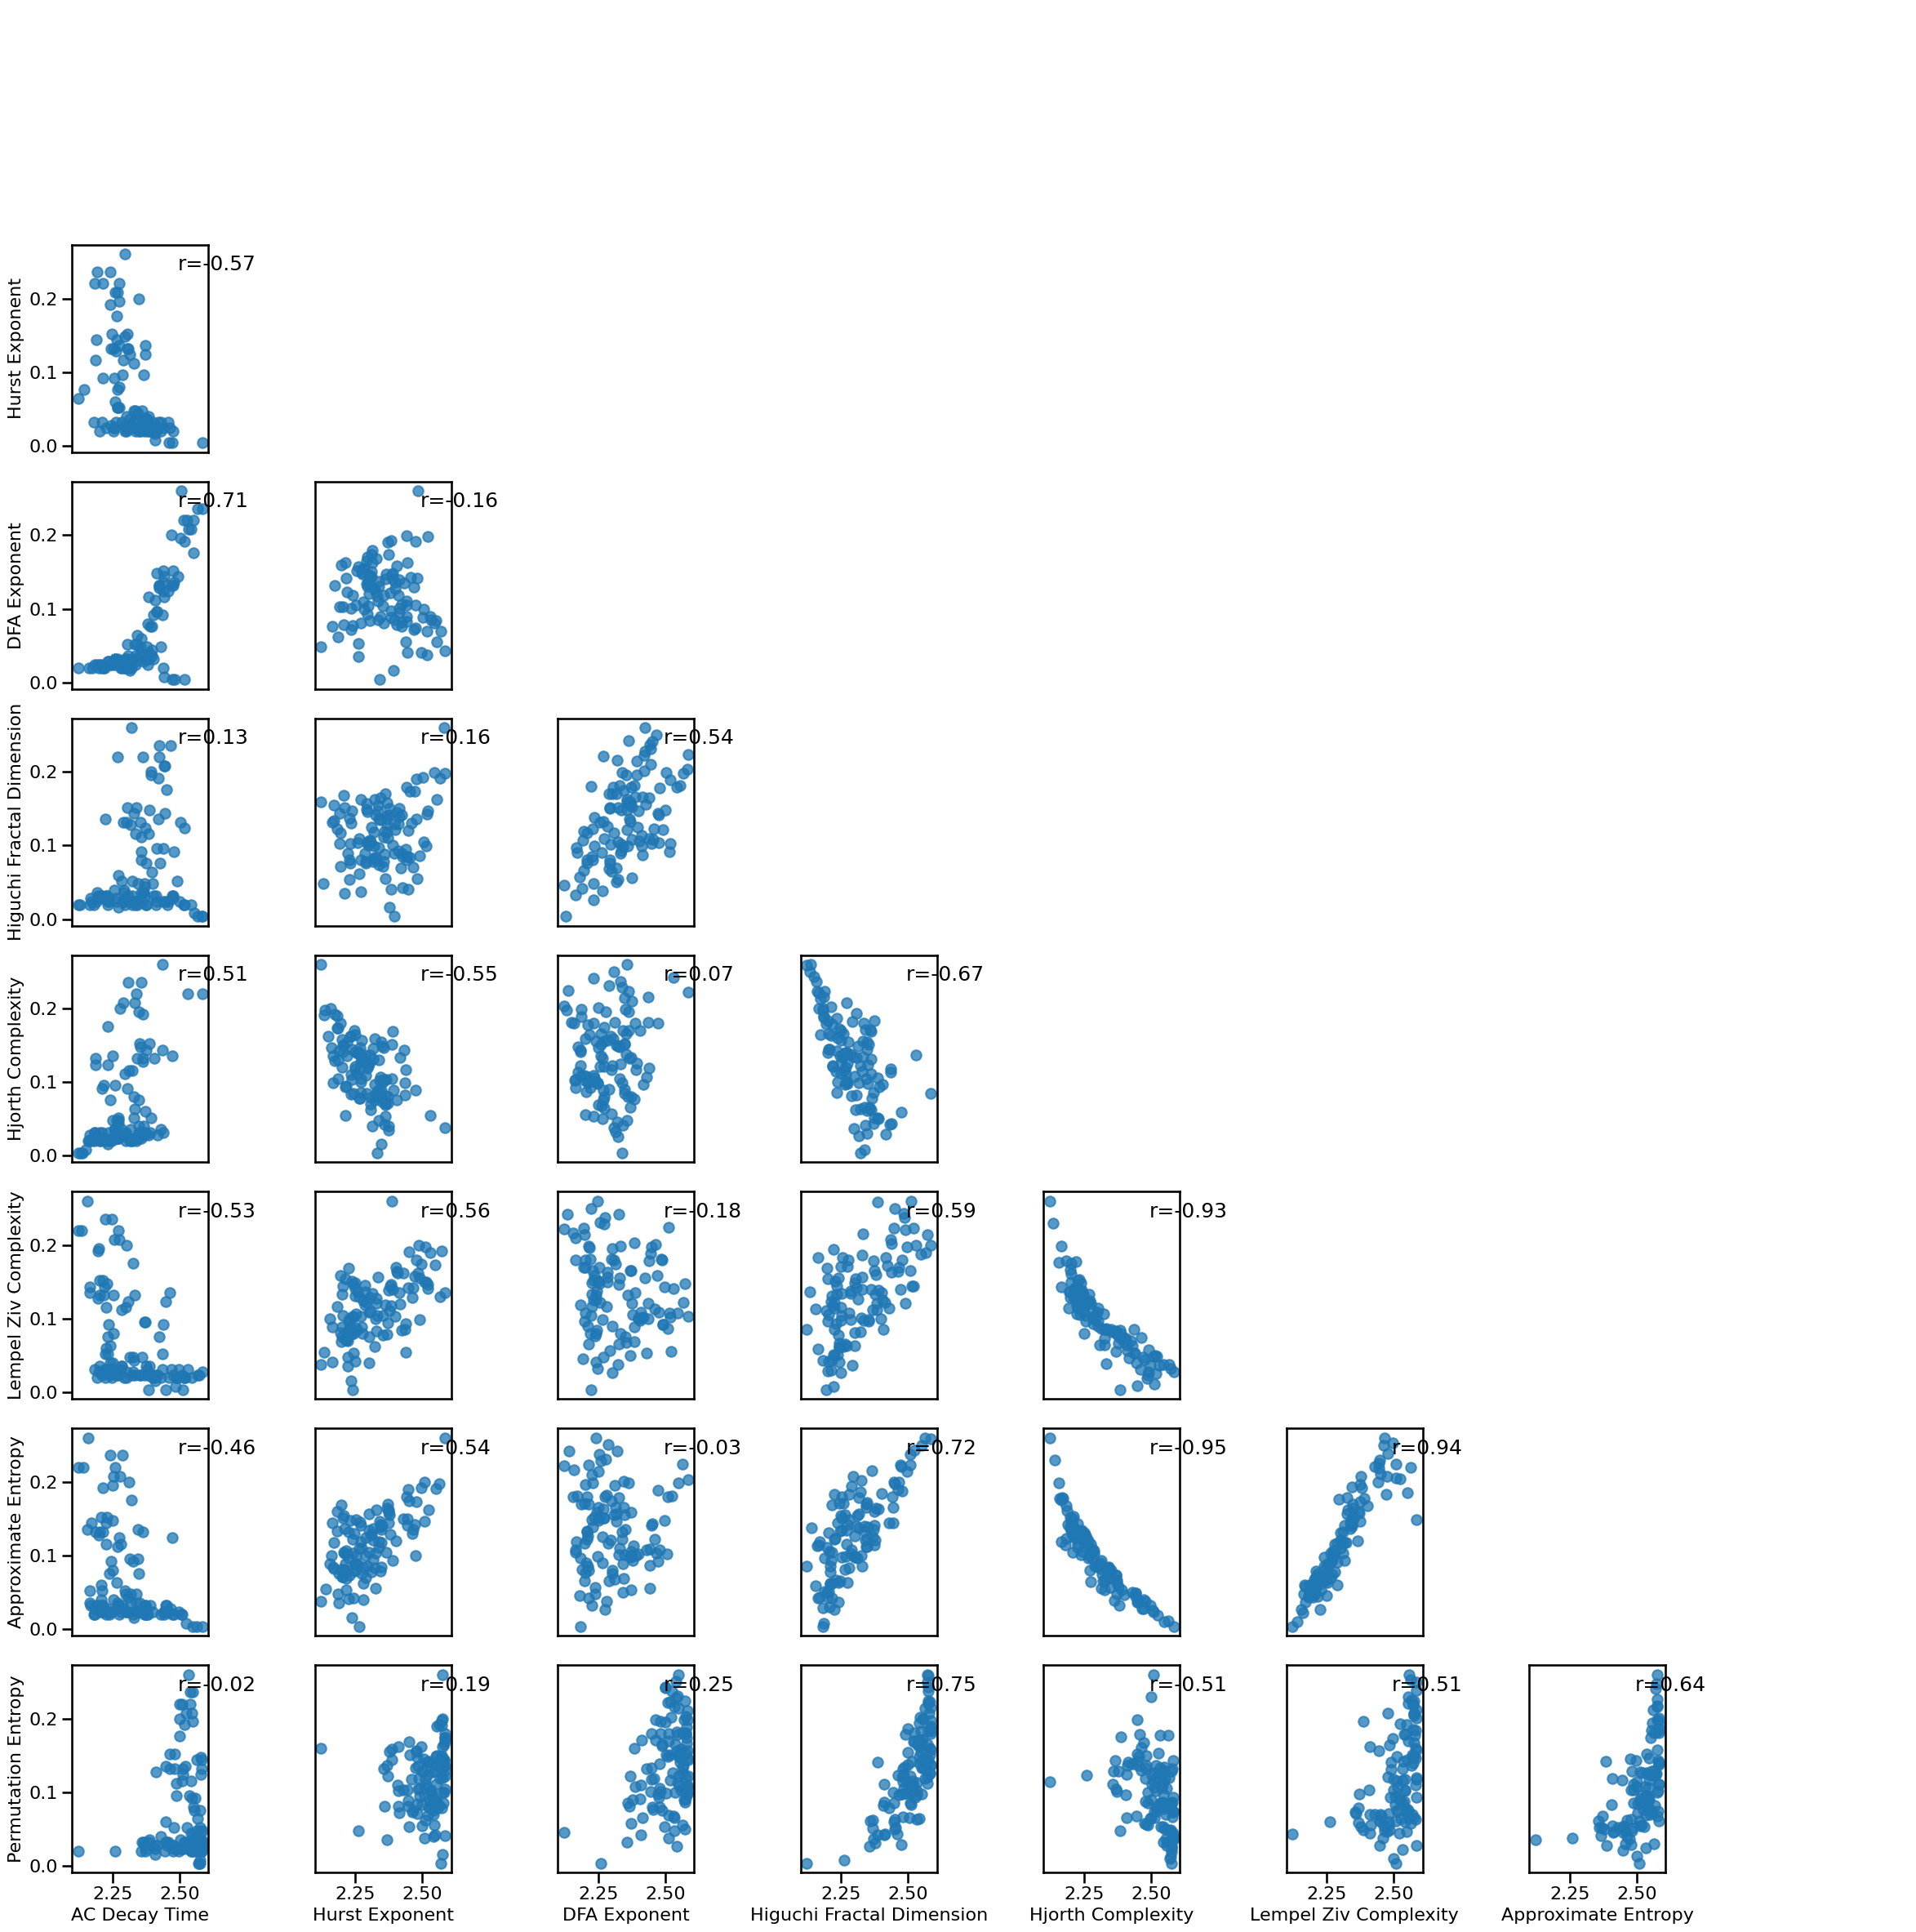

In [27]:
# Plot multi-panel plot comparing all time series measures to each other
plot_results_all(results, ts_measures)

In [28]:
all_corrs_ts = deepcopy(all_corrs)
[all_corrs_ts.pop(meas) for meas in exp_measures];

In [29]:
all_corrs_mat = unpack_corrs(all_corrs_ts)

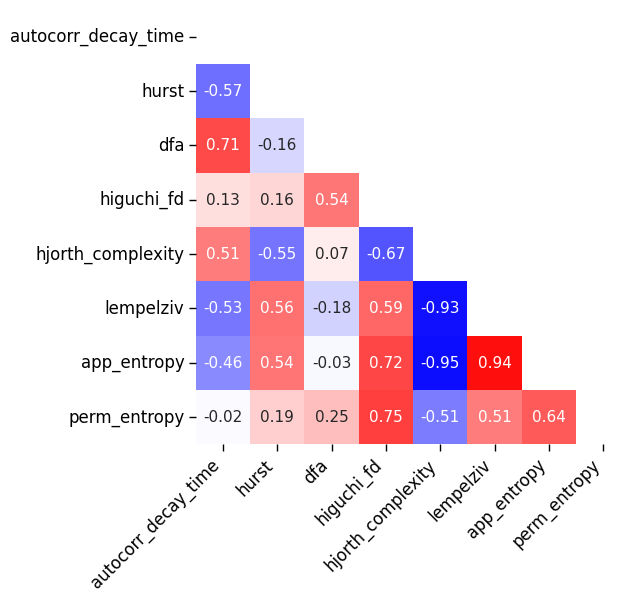

In [69]:
plot_corr_matrix(all_corrs_mat, xticklabels=ts_measures, yticklabels=ts_measures,
                 cbar=False, figsize=(6, 6))
#plt.xticks(fontsize=12, rotation=45, ha='right') 
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, fontsize=12, ha='right');
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0, fontsize=12);
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat_subjs' + EXT))

In [31]:
exp_corrs_subjs = deepcopy(all_corrs['specparam'])
exp_corrs_subjs.pop('irasa');
exp_corrs_subjs = np.atleast_2d([exp_corrs_subjs[label][0] for label in ts_measures]).T

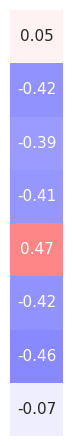

In [32]:
plot_corr_matrix(exp_corrs_subjs, xticks=[], yticks=[], cbar=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_corr_subjs' + EXT))

### Compare to Alpha Power

In [33]:
# Compute correlations between aperiodic measures and alpha power
alpha_corrs = compute_corrs_to_feature(results, peak_results['alpha_power'])

In [34]:
# Compute differences between correlations between aperiodic measures and alpha power
alpha_corr_diffs = compute_diffs_to_feature(results, peak_results['alpha_power'])

In [35]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with alpha:')
for label in alpha_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*alpha_corrs[label]))

Correlations with alpha:
     autocorr_decay_time :   r=-0.199  CI[-0.392, +0.006],  p=0.037
     hurst               :   r=+0.012  CI[-0.182, +0.212],  p=0.902
     dfa                 :   r=-0.501  CI[-0.631, -0.333],  p=0.000
     higuchi_fd          :   r=-0.596  CI[-0.706, -0.460],  p=0.000
     hjorth_complexity   :   r=+0.271  CI[+0.094, +0.436],  p=0.004
     lempelziv           :   r=-0.250  CI[-0.418, -0.066],  p=0.008
     app_entropy         :   r=-0.357  CI[-0.507, -0.188],  p=0.000
     perm_entropy        :   r=-0.463  CI[-0.597, -0.294],  p=0.000
     specparam           :   r=+0.319  CI[+0.138, +0.488],  p=0.001
     irasa               :   r=+0.450  CI[+0.283, +0.591],  p=0.000


In [36]:
alpha_corrs_ts = np.atleast_2d([alpha_corrs[label][0] for label in ts_measures]).T

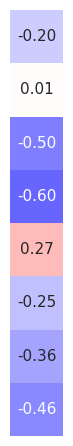

In [37]:
plot_corr_matrix(alpha_corrs_ts, xticks=[], yticks=[], cbar=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('alpha_corr_subjs' + EXT))

## Check Age Relationship

In [38]:
# Compute the correlations between each measure and age
age_corrs = compute_corrs_to_feature(results, ages)

In [39]:
# Compute the differences between measure-to-age correlations
age_corr_diffs = compute_diffs_to_feature(results, ages)

#### Check Correlations with Age

In [40]:
# Check the correlations between alpha power and aperiodic measures
print('Correlations with age:')
for label in age_corrs.keys():
    print('     {:20s}:  '.format(label), format_corr(*age_corrs[label]))

Correlations with age:
     autocorr_decay_time :   r=-0.146  CI[-0.326, +0.046],  p=0.125
     hurst               :   r=+0.415  CI[+0.249, +0.557],  p=0.000
     dfa                 :   r=+0.127  CI[-0.066, +0.304],  p=0.184
     higuchi_fd          :   r=+0.157  CI[-0.022, +0.326],  p=0.101
     hjorth_complexity   :   r=-0.218  CI[-0.393, -0.029],  p=0.021
     lempelziv           :   r=+0.213  CI[+0.026, +0.380],  p=0.025
     app_entropy         :   r=+0.260  CI[+0.088, +0.430],  p=0.006
     perm_entropy        :   r=+0.194  CI[+0.005, +0.365],  p=0.042
     specparam           :   r=-0.502  CI[-0.625, -0.354],  p=0.000
     irasa               :   r=-0.469  CI[-0.598, -0.318],  p=0.000


#### Plot age relationships

In [41]:
sns.set_context('paper')

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


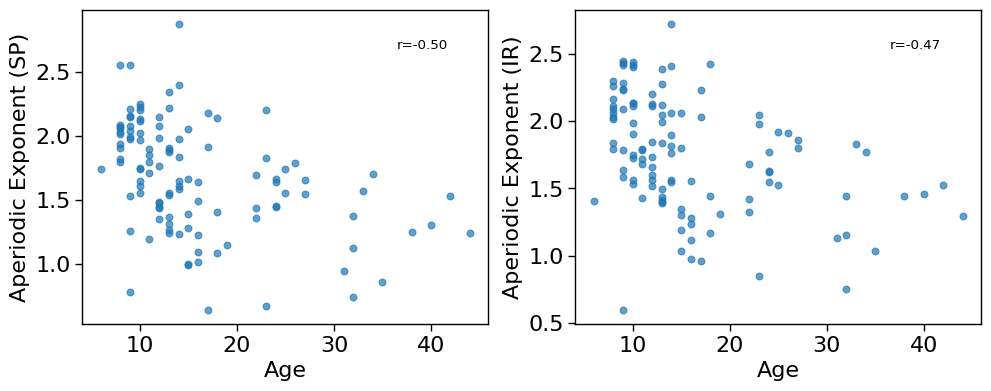

In [42]:
# Check the relationship between aperiodic exponent and age
axes = make_axes(1, 2, figsize=(10, 4), wspace=0.25)
plot_dots(ages, results['specparam'], **dot_kwargs, ax=axes[0],
          xlabel='Age', ylabel='Aperiodic Exponent (SP)')
plot_dots(ages, results['irasa'], **dot_kwargs, ax=axes[1],
          xlabel='Age', ylabel='Aperiodic Exponent (IR)')
if SAVE_FIG: plt.savefig(FIGPATH / ('mipdb_exp_age' + EXT))

/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/tom/opt/anaconda3/envs/apm/lib/python3.9/site-packages/neurodsp/plts/style.py:128: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


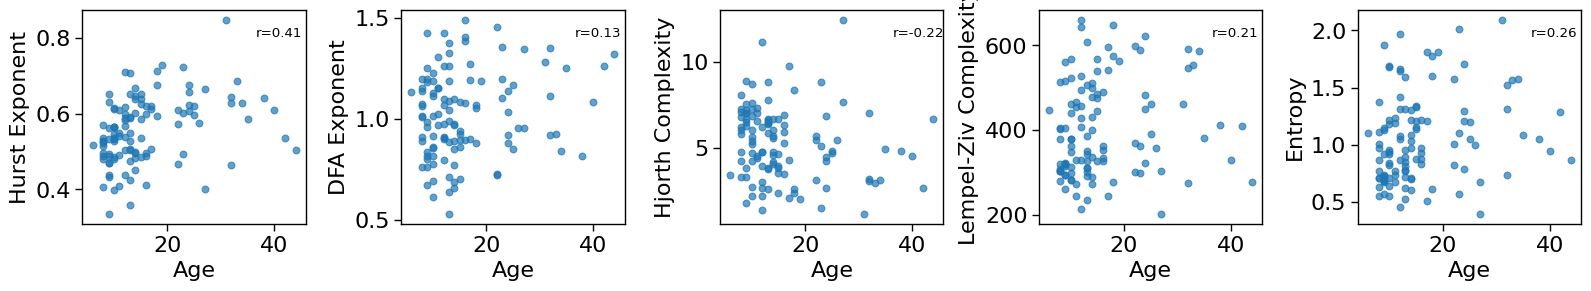

In [43]:
# Check the relationship between time domain measures and age
axes = make_axes(1, 5, figsize=(16, 3), wspace=0.15)
plot_dots(ages, results['hurst'], **dot_kwargs, ax=axes[0],
          xlabel='Age', ylabel='Hurst Exponent')
plot_dots(ages, results['dfa'], **dot_kwargs, ax=axes[1],
          xlabel='Age', ylabel='DFA Exponent')
plot_dots(ages, results['hjorth_complexity'], **dot_kwargs, ax=axes[2],
          xlabel='Age', ylabel='Hjorth Complexity')
plot_dots(ages, results['lempelziv'], **dot_kwargs, ax=axes[3],
          xlabel='Age', ylabel='Lempel-Ziv Complexity')
plot_dots(ages, results['app_entropy'], **dot_kwargs, ax=axes[4],
          xlabel='Age', ylabel='Entropy')
if SAVE_FIG: plt.savefig(FIGPATH / ('mipdb_ts_age' + EXT))

## Topographies

In [44]:
path = Path('/Users/tom/Desktop/apm_data/')

In [45]:
group_data = np.load(path / 'MIPDB_extracted_block.npy')
group_data = np.squeeze(group_data[:, 0, :, :])

### Set up montage information

In [47]:
# Read in list of channel names that are kept in reduced 111 montage
with open(path / 'chans111.csv', 'r') as csv_file:
    reader = csv.reader(csv_file)
    ch_labels = list(reader)[0]

In [48]:
montage = mne.channels.make_standard_montage('GSN-HydroCel-129')
info = mne.create_info(ch_labels, fs, 'eeg')
info = info.set_montage(montage)

### Compute Measures Across Channels

In [49]:
group_results = run_group_measures(group_data[0:5, :, :], measures)

In [50]:
group_avg = compute_avgs(group_results)

#### Exponent Topographies

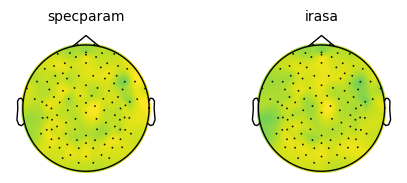

In [51]:
axes = make_axes(1, len(exp_measures), figsize=(5, 3), wspace=0.55)
for measure, ax in zip(exp_measures, axes):
    ax.set_title(measure, fontdict={'fontsize' : 10})
    plot_topomap(group_avg[measure], info, cmap=cm.viridis, contours=0, size=2, axes=ax, show=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('exp_topos' + EXT))

#### Time Series Measure Topographies

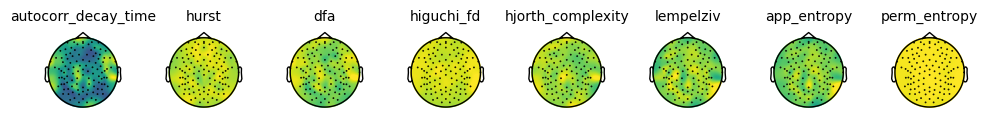

In [70]:
axes = make_axes(1, len(ts_measures), figsize=(12, 3), wspace=0.45)
for measure, ax in zip(ts_measures, axes):
    ax.set_title(measure, fontdict={'fontsize' : 10})
    plot_topomap(group_avg[measure], info, cmap=cm.viridis, contours=0, size=2, axes=ax, show=False)
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_topos' + EXT))

### Spatial Correlations

In [53]:
group_avg_ts = deepcopy(group_avg)
[group_avg_ts.pop(meas) for meas in exp_measures];

In [54]:
group_corrs = compute_all_corrs(group_avg_ts)

In [55]:
group_corrs_mat = unpack_corrs(group_corrs)

In [56]:
mask = np.triu(group_corrs_mat)
labels = list(group_corrs.keys())

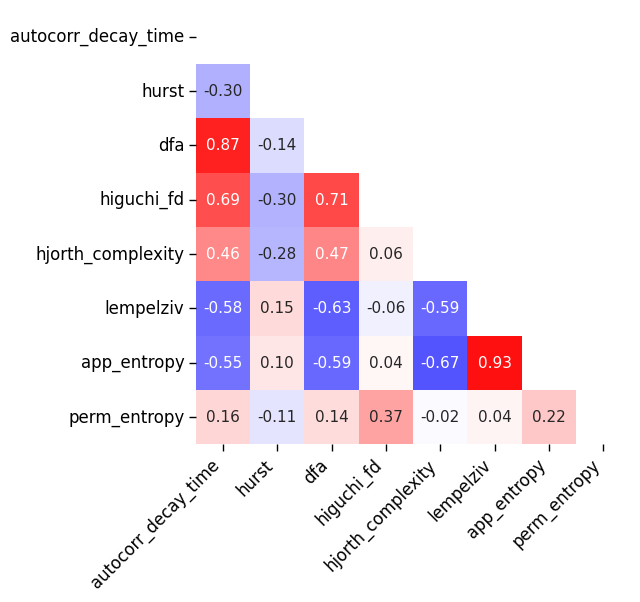

In [74]:
plot_corr_matrix(group_corrs_mat, xticklabels=ts_measures, yticklabels=ts_measures,
                 cbar=False, figsize=(6, 6))
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), rotation=45, fontsize=12, ha='right');
plt.gca().set_yticklabels(plt.gca().get_yticklabels(), rotation=0, fontsize=12);
if SAVE_FIG: plt.savefig(FIGPATH / ('ts_corr_mat_spatial' + EXT))

In [58]:
group_exp_corrs = compute_corrs_to_feature(group_avg_ts, group_avg['specparam'])

In [59]:
exp_corr_mat = np.atleast_2d([group_exp_corrs[label][0] for label in group_exp_corrs]).T

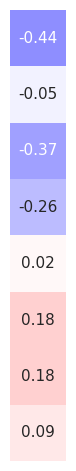

In [60]:
plot_corr_matrix(exp_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='exp_corr_space' + EXT, file_path=FIGPATH)

### Alpha Power Topography

In [61]:
group_results_peaks = run_group_measures(group_data[0:5], peak_measures)

In [62]:
group_results_peaks['alpha_power'] = np.log10(group_results_peaks['alpha_power'])

In [63]:
group_avg_peaks = compute_avgs(group_results_peaks)

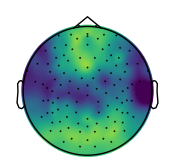

(<matplotlib.image.AxesImage at 0x7fa22fb8ee80>, None)

In [64]:
plot_topomap(group_avg_peaks['alpha_power'], info, cmap=cm.viridis,
             contours=0, size=2)#, vlim=(-11.5, -10.5))

In [65]:
# Compute correlations between aperiodic measures and alpha power
group_alpha_corrs = compute_corrs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [66]:
# Compute differences between correlations between aperiodic measures and alpha power
group_alpha_corr_diffs = compute_diffs_to_feature(group_avg_ts, group_avg_peaks['alpha_power'])

In [67]:
alpha_corr_mat = np.atleast_2d([group_alpha_corrs[label][0] for label in group_alpha_corrs]).T

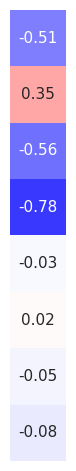

In [68]:
plot_corr_matrix(alpha_corr_mat, xticks=[], yticks=[], cbar=False,
                 save_fig=SAVE_FIG, file_name='alpha_corr_space' + EXT, file_path=FIGPATH)

## Comparison Across Blocks

ToDo...

## Conclusions

Interim conclusions from this analysis:
- specparam & IRASA estimates are consistent in this dataset
- aperiodic exponent is moderately correlated with time domain measures

Notably, these findings are a replication of the same analyses on the previous EEG dataset.

In addition, in this larger dataset, we could analyze the relationship between our measures of interest, and age, finding that:
- specparam & IRASA estimates of exponent are equivalently correlated with age
- time domain measures are more moderately correlated with age than exponent measures